This notebook demonstrates how samples from a flow can be degraded to simulate different systematics.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy
import pzflow
from pzflow import Flow
from pzflow.bijectors import Chain, ColorTransform, InvSoftplus, StandardScaler, RollingSplineCoupling
from utils import InvRedshiftIncompleteness, LineConfusion, photoz_stats

In [2]:
# plotting style
plt.style.use('../paper.mplstyle')
twocol = 7.1014
onecol = 3.35

First, we will demonstrate the `InvRedshiftIncompleteness` degrader. It applies a selection function, which keeps galaxies with probability $p_{\text{keep}}(z) = \min(1, \frac{z_p}{z})$, where $z_p$ is the ''pivot'' redshift. We'll use $z_p = 0.8$.

Let's create a samples from a creator with and without this selection function, and compare their redshift distributions.

In [3]:
flow = Flow(file="saved-flows/desc-dc2-dr6-redshift-flow.pkl")

In [4]:
complete_sample = flow.sample(100000, seed=0)
incomplete_sample = InvRedshiftIncompleteness(0.8)(flow.sample(150000, seed=0))[:100000]

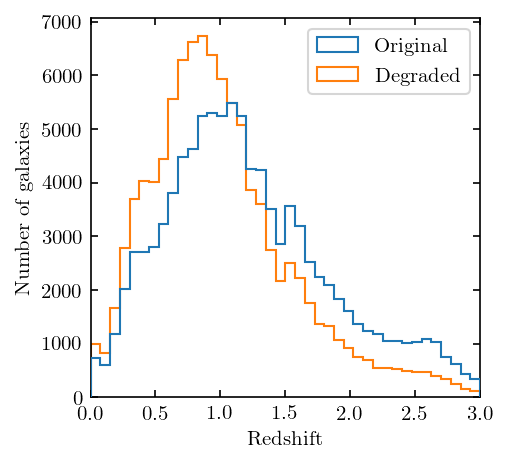

In [5]:
fig, ax = plt.subplots()
ax.hist(complete_sample['redshift'], bins=40, range=(0, 3), histtype='step', label="Original", zorder=10)
ax.hist(incomplete_sample['redshift'], bins=40, range=(0, 3), histtype='step', label="Degraded")
ax.legend()
ax.set(xlabel="Redshift", ylabel="Number of galaxies", xlim=(0, 3))
plt.show()

We can see that the biased samples have more low redshift galaxies, and a deficit of galaxies with redshift > 0.8.

Now let's train a flow as a photo-z estimator on the degraded sample.

In [6]:
# set the Color Transform reference index
# to use the r band as the reference magnitude
ref_idx = incomplete_sample.columns.get_loc("r")
# set the column indices for the magnitudes we want colors from
mag_idx = [incomplete_sample.columns.get_loc(col) for col in ["u","g","r","i","z","y"]]

# set the inverse softplus parameters, 
# to ensure that sampled redshifts are positive
column_idx = 0
sharpness = 10

# calculate the mean and standard deviations of the dimensions
# note that on this side of the color transform, we are working
# in color space, so I calculate the mean and std dev of these 
# variables instead of the raw magnitudes
data_temp = np.array([incomplete_sample['redshift'], 
                      incomplete_sample['r'], 
                      incomplete_sample['u'] - incomplete_sample['g'], 
                      incomplete_sample['g'] - incomplete_sample['r'], 
                      incomplete_sample['r'] - incomplete_sample['i'], 
                      incomplete_sample['i'] - incomplete_sample['z'], 
                      incomplete_sample['z'] - incomplete_sample['y']]).T

means = data_temp.mean(axis=0)
stds = data_temp.std(axis=0)
del data_temp

# set number of layers in the RollingSplineCoupling
# equal to the input dimension
nlayers = incomplete_sample.shape[1]

# construct our bijector
# by chaining all these layers
bijector = Chain(
    ColorTransform(ref_idx, mag_idx),
    InvSoftplus(column_idx, sharpness),
    StandardScaler(means, stds),
    RollingSplineCoupling(nlayers, K=2),
)

In [7]:
%%time
incomplete_flow = Flow(incomplete_sample.columns, bijector)
incomplete_losses = incomplete_flow.train(incomplete_sample, epochs=200, verbose=True)

Training 200 epochs 
Loss:
6.6586
-2.5418
-4.7283
-5.5253
-5.7714
-5.8941
-6.1419
-6.3596
-6.2946
-6.4908
-6.4286
-6.4742
-6.5842
-6.6139
-6.7113
-6.6973
-6.7054
-6.7473
-6.7541
-6.7166
-6.7483
CPU times: user 6min 45s, sys: 10min 27s, total: 17min 12s
Wall time: 6min 41s


In [8]:
incomplete_flow.info = f"""
Flow for the forward model section of the pzflow paper.
Trained on an incomplete set of 100,000 galaxies from DESC DC2 DR6.

This flow was created with pzflow version {pzflow.__version__}
"""
incomplete_flow.save("saved-flows/incomplete-redshift-flow.pkl")

Now, let's demonstrate `LineConfusion`. This is a degrader that simulates spectroscopic errors resulting from the confusion of different emission lines.

Let's use the `LineConfusion` degrader to create an `OxygenLineConfusion` degrader, in which 2% of [OII] lines are mistaken as [OIII] lines, and 1% of [OIII] lines are mistaken as [OII] lines.

Again, we will make samples with and without this degradation, this time comparing the spec-z's

In [18]:
def OxygenLineConfusion(data, seed=None):
    OII = 3727
    OIII = 5007
    
    data = LineConfusion(true_wavelen=OII, wrong_wavelen=OIII, frac_wrong=0.02)(data, seed)
    data = LineConfusion(true_wavelen=OIII, wrong_wavelen=OII, frac_wrong=0.01)(data, seed)
    return data

In [12]:
specz_err_sample = OxygenLineConfusion(complete_sample, seed=0)

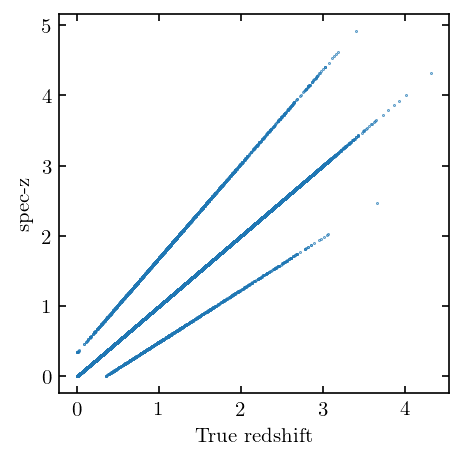

In [13]:
fig, ax = plt.subplots()
ax.scatter(complete_sample["redshift"], specz_err_sample["redshift"], s=0.1)
ax.set(xlabel="True redshift", ylabel="spec-z")
plt.show()

The galaxies above the line y=x are the [OII] -> [OIII] galaxies, while the ones below are the [OIII] -> [OII] galaxies.

Now let's train a flow as a photo-z estimator on the sample with spec-z errors.

In [14]:
%%time
specz_err_flow = Flow(specz_err_sample.columns, bijector)
specz_err_losses = specz_err_flow.train(specz_err_sample, epochs=200, verbose=True)

Training 200 epochs 
Loss:
6.7344
-1.2468
-4.0458
-4.0254
-4.8840
-5.0377
-5.1372
-5.3321
-5.5073
-5.4359
-5.5407
-5.5475
-5.7036
-5.6764
-5.6746
-5.7812
-5.7174
-5.7268
-5.8093
-5.9117
-5.9212
CPU times: user 6min 1s, sys: 51.7 s, total: 6min 52s
Wall time: 3min 46s


In [15]:
specz_err_flow.info = f"""
Flow for the forward model section of the pzflow paper.
Trained on a set of 100,000 galaxies with spec-z errors from DESC DC2 DR6.

This flow was created with pzflow version {pzflow.__version__}
"""
specz_err_flow.save("saved-flows/specz-err-redshift-flow.pkl")

Now let's train one more flow on the complete sample, to serve as a benchmark for photo-z estimation.

In [61]:
# set the Color Transform reference index
# to use the r band as the reference magnitude
ref_idx = complete_sample.columns.get_loc("r")
# set the column indices for the magnitudes we want colors from
mag_idx = [complete_sample.columns.get_loc(col) for col in ["u","g","r","i","z","y"]]

# set the inverse softplus parameters, 
# to ensure that sampled redshifts are positive
column_idx = 0
sharpness = 10

# calculate the mean and standard deviations of the dimensions
# note that on this side of the color transform, we are working
# in color space, so I calculate the mean and std dev of these 
# variables instead of the raw magnitudes
data_temp = np.array([complete_sample['redshift'], 
                      complete_sample['r'], 
                      complete_sample['u'] - complete_sample['g'], 
                      complete_sample['g'] - complete_sample['r'], 
                      complete_sample['r'] - complete_sample['i'], 
                      complete_sample['i'] - complete_sample['z'], 
                      complete_sample['z'] - complete_sample['y']]).T

means = data_temp.mean(axis=0)
stds = data_temp.std(axis=0)
del data_temp

# set number of layers in the RollingSplineCoupling
# equal to the input dimension
nlayers = complete_sample.shape[1]

# construct our bijector
# by chaining all these layers
bijector = Chain(
    ColorTransform(ref_idx, mag_idx),
    InvSoftplus(column_idx, sharpness),
    StandardScaler(means, stds),
    RollingSplineCoupling(nlayers, K=2),
)

In [62]:
%%time
complete_flow = Flow(complete_sample.columns, bijector)
complete_losses = complete_flow.train(complete_sample, epochs=200, verbose=True)

Training 200 epochs 
Loss:
6.9276
-1.7661
-4.4636
-5.1643
-5.3414
-5.9191
-5.9738
-6.0285
-6.1453
-6.2383
-6.2483
-6.2828
-6.2901
-6.4341
-6.2502
-6.5080
-6.3622
-6.4991
-6.5441
-6.5639
-6.5531
CPU times: user 6min 33s, sys: 59.7 s, total: 7min 32s
Wall time: 4min 12s


In [77]:
complete_flow.save("saved-flows/complete-redshift-flow.pkl")

Load all the flows trained above.

In [3]:
flow = Flow(file="saved-flows/desc-dc2-dr6-redshift-flow.pkl")
complete_flow = Flow(file="saved-flows/complete-redshift-flow.pkl")
incomplete_flow = Flow(file="saved-flows/incomplete-redshift-flow.pkl")
specz_err_flow = Flow(file="saved-flows/specz-err-redshift-flow.pkl")

In [4]:
complete_sample = flow.sample(100000, seed=0)

Let's calculate a bunch of posteriors and print some stats

In [5]:
grid = np.arange(0, 3.02, 0.02)
true_pdfs = flow.posterior(complete_sample, column="redshift", grid=grid, batch_size=10000)
complete_pdfs = complete_flow.posterior(complete_sample, column="redshift", grid=grid, batch_size=10000)
incomplete_pdfs = incomplete_flow.posterior(complete_sample, column="redshift", grid=grid, batch_size=10000)
specz_err_pdfs = specz_err_flow.posterior(complete_sample, column="redshift", grid=grid, batch_size=10000)

In [9]:
def zmode(pdfs):
    return grid[np.argmax(pdfs, axis=1)]

In [7]:
for name, pdfs in zip(["true", "complete", "incomplete", "specz_err"],
                      [true_pdfs, complete_pdfs, incomplete_pdfs, specz_err_pdfs]):
    print(f"Median KLDiv of {name}: {np.median(entropy(pdfs, qk=true_pdfs, axis=1))}")

Median KLDiv of true: 0.0
Median KLDiv of complete: 0.21246454119682312
Median KLDiv of incomplete: 0.23727597296237946
Median KLDiv of specz_err: 0.29101699590682983


In [15]:
for name, pdfs in zip(["true", "complete", "incomplete", "specz_err"],
                      [true_pdfs, complete_pdfs, incomplete_pdfs, specz_err_pdfs]):
    bias, sig, fout = photoz_stats(zmode(pdfs), complete_sample["redshift"].values)
    print(f"{name}: bias - {bias:.5f}, std - {sig:.3f}, fout - {fout:.3f}")

true: bias - -0.00004, std - 0.005, fout - 0.043
complete: bias - 0.00032, std - 0.006, fout - 0.057
incomplete: bias - 0.00009, std - 0.006, fout - 0.066
specz_err: bias - 0.00054, std - 0.006, fout - 0.058


Let's also make a plot showing these two biases

In [19]:
incomplete_sample = InvRedshiftIncompleteness(0.8)(flow.sample(150000, seed=0))[:100000]
specz_err_sample = OxygenLineConfusion(complete_sample, seed=0)

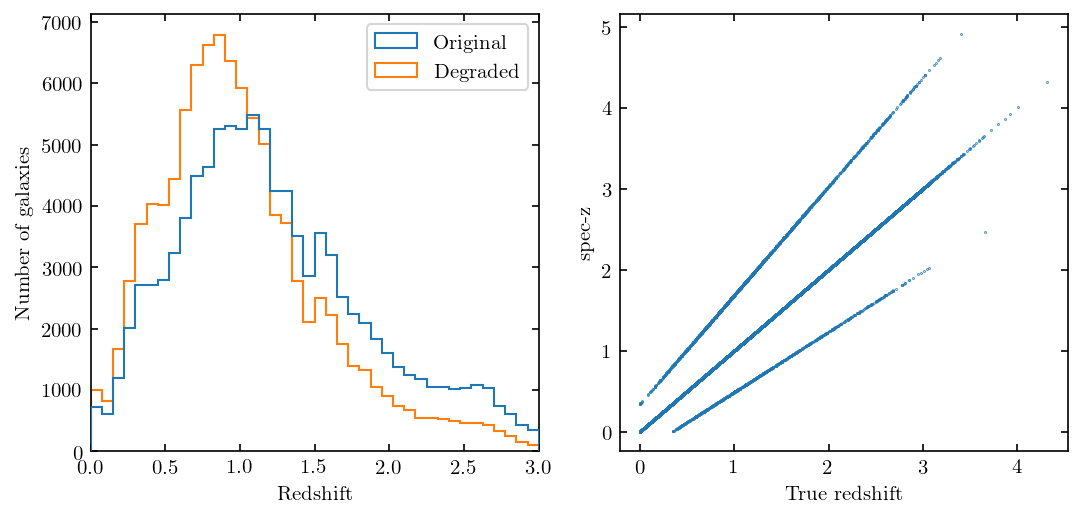

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(twocol, onecol), constrained_layout=True)

ax1.hist(complete_sample['redshift'], bins=40, range=(0, 3), histtype='step', label="Original", zorder=10)
ax1.hist(incomplete_sample['redshift'], bins=40, range=(0, 3), histtype='step', label="Degraded")
ax1.legend()
ax1.set(xlabel="Redshift", ylabel="Number of galaxies", xlim=(0, 3))

ax2.scatter(complete_sample["redshift"], specz_err_sample["redshift"], s=0.1)
ax2.set(xlabel="True redshift", ylabel="spec-z")

fig.savefig("figures/degradation-demo.pdf")